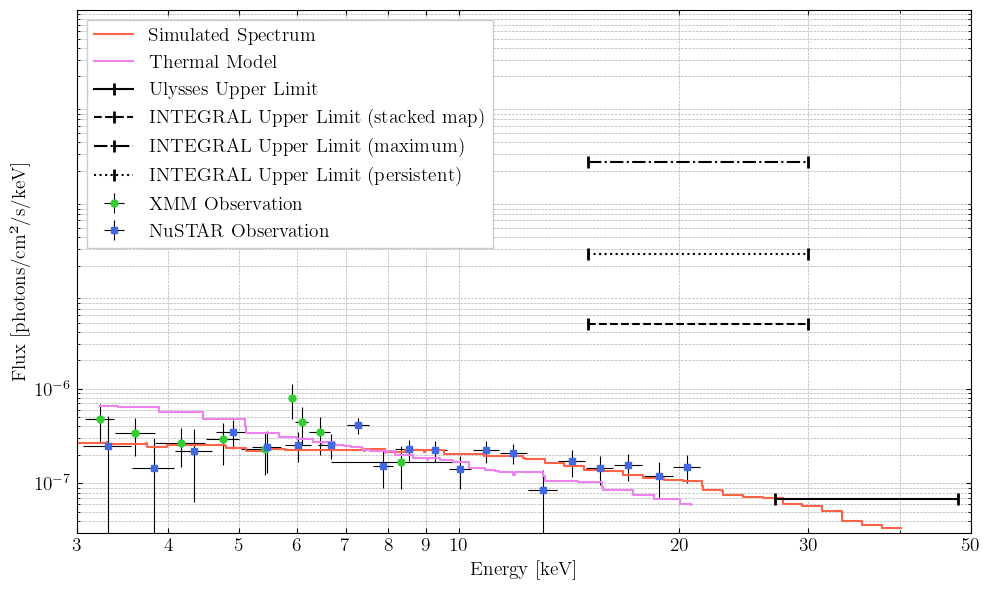

In [74]:
import csv
import numpy as np
import matplotlib.pyplot as plt

filename = '../data/digitized-spectra.csv'

curves = {}
current_label = None
x_vals = []
y_vals = []

label_map = {
    "Curve1": "XMM Observation",
    "Curve2": "NuSTAR Observation",
    "Curve3": "Simulated Spectrum",
    "Curve4": "Thermal Model",
    "Curve5": "Ulysses Upper Limit",
}

XMM_x_errors = [0.3, 0.45, 0.65, 0.5, 0.8, 0.1, 0.25, 0.43, 3.3]
XMM_y_errors = [4.2e-7, 3e-7, 2.4e-7, 2.8e-7, 2.2e-7, 6.6e-7, 3.8e-7, 3.1e-7, 1.6e-7]

NuSTAR_x_errors = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.9, 1.0, 1.2, 1.2, 1.3, 1.5, 1.7, 1.7]
NuSTAR_y_errors = [5.2e-7, 3.1e-7, 3.1e-7, 2.4e-7, 2.3e-7, 1.8e-7, 1.5e-7, 1.5e-7, 1.3e-7, 1.2e-7, 1.1e-7, 1.1e-7, 1.2e-7, 1e-7, 1.1e-7, 1.1e-7, 1e-7, 1e-7, 1e-7, 1e-7] # +- 0.01e-7

with open(filename, 'r') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue  
        if line.lower().startswith('x'):
            if current_label and x_vals:
                curves[current_label] = (np.array(x_vals), np.array(y_vals))
            
            parts = line.split(',')
            current_label = parts[1].strip()
            x_vals = []
            y_vals = []
        else:
            try:
                x, y = map(float, line.split(','))
                x_vals.append(x)
                y_vals.append(y)
            except ValueError:
                continue  

if current_label and x_vals:
    curves[current_label] = (np.array(x_vals), np.array(y_vals))


step_like_curves = ["Curve3", "Curve4"]
tolerance = 1e-4  # tolerance for detecting duplicate x-values

def make_step_curve(x, y, tol=1e-3):
    x = np.array(x)
    y = np.array(y)

    x_out = [x[0]]
    y_out = [y[0]]

    for i in range(1, len(x)):
        # If x[i] is close to x[i-1], then it marks a vertical edge
        if np.abs(x[i] - x[i - 1]) < tol:
            # duplicate the previous Y to create a flat segment
            y_out.append(y[i])
            x_out.append(x[i])
        else:
            # regular horizontal step
            y_out.append(y[i])
            x_out.append(x[i])
    return np.array(x_out), np.array(y_out)


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

colors = plt.cm.Dark2.colors

# Plotting
plt.figure(figsize=(10, 6))
for idx, (label, (x, y)) in enumerate(curves.items()):
    new_label = label_map.get(label, label)
    if new_label == "XMM Observation":
        plt.errorbar(x, y, xerr=np.array(XMM_x_errors)/2, yerr=np.array(XMM_y_errors)/2,
                 fmt='o', markersize=5, color='limegreen', ecolor='black', label=new_label,
                 elinewidth=0.8, capsize=0, linestyle='None')
    elif new_label == "NuSTAR Observation":
        plt.errorbar(x, y, xerr=np.array(NuSTAR_x_errors)/2, yerr=np.array(NuSTAR_y_errors)/2,
                 fmt='s', markersize=5, color='royalblue', ecolor='black', label=new_label,
                 elinewidth=0.8, capsize=0, linestyle='None')
    elif label in step_like_curves:
        x_step, y_step = make_step_curve(x, y, tol=tolerance)
        if label == "Curve3":
            plt.step(x_step, y_step, where='post', label=new_label, color='tomato')
        elif label == "Curve4":
            plt.step(x_step, y_step, where='post', label=new_label, color='violet')
    else:
        plt.plot(x, y, label=new_label, color='k', marker='|', markersize=8, markeredgewidth=2)

# Plot my upper limits
upper_limit =  1.08e-04/((15+30)/2) 
upper_limit_x = np.array([15, 30])
plt.plot(upper_limit_x, [upper_limit, upper_limit], color='black', linestyle='--', label=r'INTEGRAL Upper Limit (stacked map)', marker='|', markersize=8, markeredgewidth=2)

upper_limit =  5.602e-03/((15+30)/2)
upper_limit_x = np.array([15, 30])
plt.plot(upper_limit_x, [upper_limit, upper_limit], color='black', linestyle='-.', label=r'INTEGRAL Upper Limit (maximum)', marker='|', markersize=8, markeredgewidth=2)

upper_limit =  5.894e-04/((15+30)/2)
upper_limit_x = np.array([15, 30])
plt.plot(upper_limit_x, [upper_limit, upper_limit], color='black', linestyle=':', label=r'INTEGRAL Upper Limit (persistent)', marker='|', markersize=8, markeredgewidth=2)

plt.xlabel(r"Energy [keV]", fontsize=14)
plt.ylabel(r"Flux [photons/cm²/s/keV]", fontsize=14)

plt.xscale('log')
plt.yscale('log')
plt.xlim(3, 50)
plt.ylim(3e-8, 1e-2)#1.2e-6)

plt.xticks([3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50], [r'3', r'4', r'5', r'6', r'7', r'8', r'9', r'10', r'20', r'30', r'50'], fontsize=14)
plt.yticks([1e-7, 1e-6], [r'$10^{-7}$', r'$10^{-6}$'], fontsize=14)

plt.tick_params(which='both', labelsize=14, direction="in")
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')

plt.legend(fontsize=14, loc='upper left', fancybox=False, framealpha=1.0)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

## Ulysses paper

In [38]:
# Distance to Jupiter in 2003
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy import units as u

jupiter = Horizons(id='599', location='@0',epochs=Time('1992-02-20', format='isot').mjd) 
eph = jupiter.ephemerides()
D = eph['delta']
D = D[0]
D *= u.AU
print(D)
D = D.to(u.cm)

5.39908781247476 AU


In [ ]:
# Convert W to photons/cm²/s (Ulysses article data)
E = 37.5 * u.keV
P = [1.1e8, 1.9e8, 5.6e8] * u.watt
J = E.to(u.joule)
F = P / (4 * np.pi * D**2) / J
F = F.to(u.cm**(-2) * u.s**(-1))
F = F / E
print(F)

[5.95550078e-09 1.02867741e-08 3.03189131e-08] 1 / (keV s cm2)


In [64]:
# Convert my upper limit to W
E = (15+30) / 2 * u.keV
E = E.to(u.erg)
limit = [5.894e-04, 5.602e-03] * u.cm**(-2) * u.s**(-1) # photons/cm²/s (this value is 3 * weighted average error and max flux)
S = E * limit
L = S * 4 * np.pi * D**2
P = L.to(u.watt)
print(f'{P[0]:.2e}', f'{P[1]:.2e}')

1.74e+11 W 1.66e+12 W


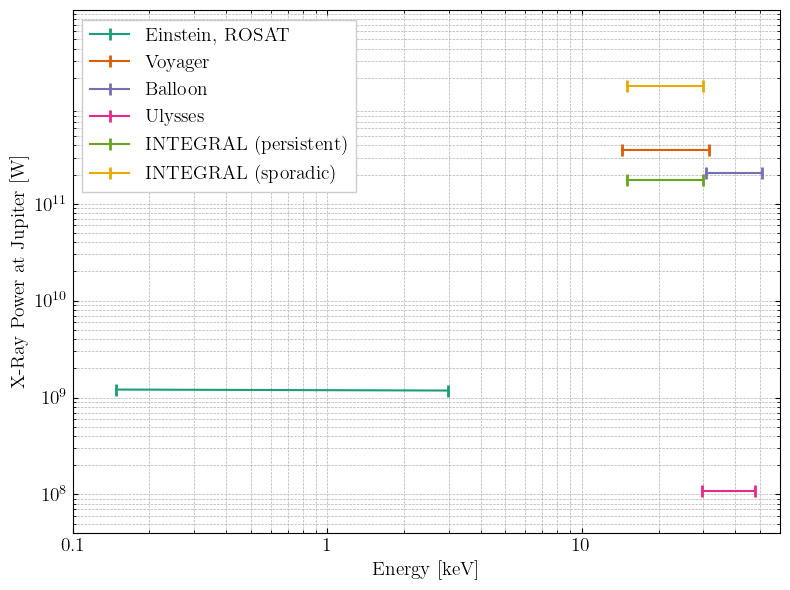

In [69]:
filename = '../data/digitized-upperlimits.csv'

curves = {}
current_label = None
x_vals = []
y_vals = []

label_map = {
    "Curve1": "Einstein, ROSAT",
    "Curve2": "Voyager",
    "Curve3": "Balloon",
    "Curve4": "Ulysses",
}

with open(filename, 'r') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue  
        if line.lower().startswith('x'):
            if current_label and x_vals:
                curves[current_label] = (np.array(x_vals), np.array(y_vals))
            
            parts = line.split(',')
            current_label = parts[1].strip()
            x_vals = []
            y_vals = []
        else:
            try:
                x, y = map(float, line.split(','))
                x_vals.append(x)
                y_vals.append(y)
            except ValueError:
                continue  

if current_label and x_vals:
    curves[current_label] = (np.array(x_vals), np.array(y_vals))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

colors = plt.cm.Dark2.colors

# Plotting
plt.figure(figsize=(8, 6))
for idx, (label, (x, y)) in enumerate(curves.items()):
    new_label = label_map.get(label, label)
    plt.plot(x, y, label=new_label, color=colors[idx], marker='|', markersize=8, markeredgewidth=2)

# Plot my upper limit (persistent)
upper_limit_persistent =  P[0].value
plt.plot(np.array([15, 30]), [upper_limit_persistent, upper_limit_persistent], color=colors[idx+1], label=r'INTEGRAL (persistent)',marker='|', markersize=8, markeredgewidth=2)

# Plot my upper limit (sporadic)
upper_limit_sporadic =  P[1].value
plt.plot(np.array([15, 30]), [upper_limit_sporadic, upper_limit_sporadic], color=colors[idx+2], label=r'INTEGRAL (sporadic)',marker='|', markersize=8, markeredgewidth=2)

plt.xlabel(r"Energy [keV]", fontsize=14)
plt.ylabel(r"X-Ray Power at Jupiter [W]", fontsize=14)

plt.xscale('log')
plt.yscale('log')
plt.xlim(0.1, 60)
plt.ylim(4e7, 1e13)

plt.xticks([0.1, 1, 10], [r'0.1', r'1', r'10'], fontsize=14)
plt.yticks([1e8, 1e9, 1e10, 1e11], [r'$10^{8}$', r'$10^{9}$', r'$10^{10}$', r'$10^{11}$'], fontsize=14)

plt.tick_params(which='both', labelsize=14, direction="in")
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')

plt.legend(fontsize=14, loc='upper left', fancybox=False, framealpha=1.0)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()